data preprocess

In [3]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

dataset_path = "Dataset/dataset_for_traffic_project_assignment/training_dataset.csv"

df = pd.read_csv(dataset_path, sep=";")


In [4]:
df.shape

(1921967, 11)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1921967 entries, 0 to 1921966
Data columns (total 11 columns):
 #   Column        Dtype  
---  ------        -----  
 0   DP_ID         int64  
 1   PORTAL        object 
 2   Date          int64  
 3   Time          object 
 4   Interval_1    int64  
 5   Interval_5    int64  
 6   Interval_15   int64  
 7   Interval_30   int64  
 8   Interval_60   int64  
 9   SPEED_MS_AVG  float64
 10  FLOW          float64
dtypes: float64(2), int64(7), object(2)
memory usage: 161.3+ MB


## 1.2 Data Preprocessing Steps

In [6]:
df_processed = df.copy()

if not pd.api.types.is_datetime64_any_dtype(df_processed['Date']):
    df_processed['Date'] = pd.to_datetime(df_processed['Date'].astype(str), format='%Y%m%d')

time_dt = pd.to_datetime(df_processed['Time'], format='%H:%M:%S')
df_processed['Day'] = df_processed['Date'].dt.day_name()
df_processed['Month'] = df_processed['Date'].dt.month_name()
df_processed['Hour'] = time_dt.dt.hour
df_processed['Minute'] = time_dt.dt.minute
df_processed['Minute_Of_Day'] = df_processed['Hour'] * 60 + df_processed['Minute']


In [7]:
day_mapping = {'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6, 'Sunday': 7}
df_processed['Day_ID'] = df_processed['Day'].map(day_mapping)

month_mapping = {'June': 6, 'July': 7, 'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12}
df_processed['Month_ID'] = df_processed['Month'].map(month_mapping)

df_processed['Is_Weekend'] = df_processed['Day_ID'].isin([6, 7]).astype(int)
df_processed['Is_Peak_Morning'] = df_processed['Minute_Of_Day'].between(7 * 60 + 30, 8 * 60 + 30).astype(int)
df_processed['Daily_Sin'] = np.sin(2 * np.pi * df_processed['Minute_Of_Day'] / 1440.0)
df_processed['Daily_Cos'] = np.cos(2 * np.pi * df_processed['Minute_Of_Day'] / 1440.0)


In [8]:
portal_numbers = df_processed['PORTAL'].astype(str).str.extract(r'(\d+[\.,]?\d*)', expand=False)
portal_numbers = portal_numbers.str.replace('[^0-9]', '', regex=True)
df_processed['Portal_Pos'] = pd.to_numeric(portal_numbers, errors='coerce')

df_processed['Portal_Flow_Mean'] = df_processed.groupby('PORTAL')['FLOW'].transform('mean')
df_processed['Portal_Speed_Mean'] = df_processed.groupby('PORTAL')['SPEED_MS_AVG'].transform('mean')

model_dataframe = df_processed.drop(columns=['Day', 'Month']).copy()


In [9]:
#print('After preprocessing:')
#df_processed.info()
print('Model dataframe columns:')
model_dataframe.info()


Model dataframe columns:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1921967 entries, 0 to 1921966
Data columns (total 23 columns):
 #   Column             Dtype         
---  ------             -----         
 0   DP_ID              int64         
 1   PORTAL             object        
 2   Date               datetime64[ns]
 3   Time               object        
 4   Interval_1         int64         
 5   Interval_5         int64         
 6   Interval_15        int64         
 7   Interval_30        int64         
 8   Interval_60        int64         
 9   SPEED_MS_AVG       float64       
 10  FLOW               float64       
 11  Hour               int32         
 12  Minute             int32         
 13  Minute_Of_Day      int32         
 14  Day_ID             int64         
 15  Month_ID           int64         
 16  Is_Weekend         int32         
 17  Is_Peak_Morning    int32         
 18  Daily_Sin          float64       
 19  Daily_Cos          float64       
 20 

## 1.3 Correlation Matrix

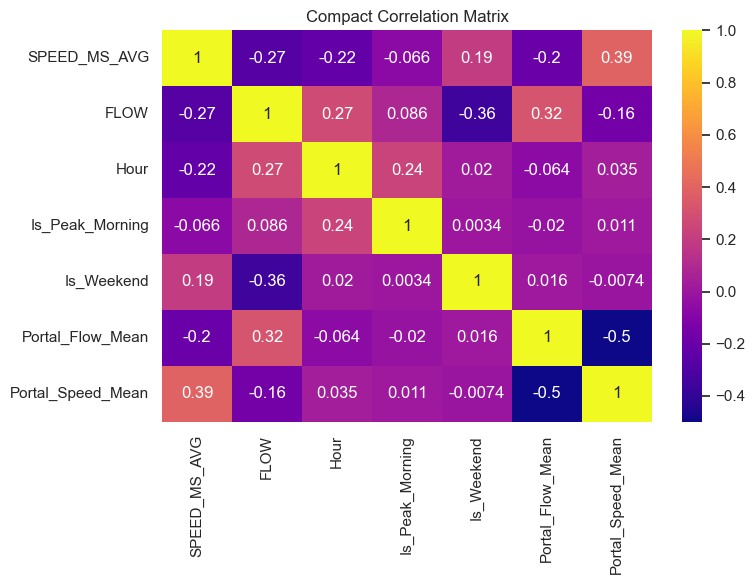

In [10]:
corr_features = [
    'SPEED_MS_AVG',
    'FLOW',
    'Hour',
    'Is_Peak_Morning',
    'Is_Weekend',
    'Portal_Flow_Mean',
    'Portal_Speed_Mean'
]

corr_matrix = model_dataframe[corr_features].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='plasma', square=False)
plt.title('Compact Correlation Matrix')
plt.tight_layout()
plt.show()


## here need to add descriptive analysis

# .....

## 1.4 Feature Cleanup and Scaling

In [11]:
model_ready = model_dataframe.copy()
model_ready = model_ready.drop(columns=['Time', 'PORTAL'], errors='ignore')
print('Columns currently available:', model_ready.columns.tolist())


Columns currently available: ['DP_ID', 'Date', 'Interval_1', 'Interval_5', 'Interval_15', 'Interval_30', 'Interval_60', 'SPEED_MS_AVG', 'FLOW', 'Hour', 'Minute', 'Minute_Of_Day', 'Day_ID', 'Month_ID', 'Is_Weekend', 'Is_Peak_Morning', 'Daily_Sin', 'Daily_Cos', 'Portal_Pos', 'Portal_Flow_Mean', 'Portal_Speed_Mean']


In [12]:
peak_mask = (df_processed['Minute_Of_Day'] >= 7 * 60) & (df_processed['Minute_Of_Day'] <= 8 * 60 + 30)
peak_data = model_ready[peak_mask].copy()

columns_to_remove = ['Date', 'Interval_1', 'Interval_5', 'Interval_15', 'Interval_30', 'Interval_60', 'Minute', 'Minute_Of_Day', 'Daily_Sin', 'Daily_Cos']
peak_data = peak_data.drop(columns=columns_to_remove, errors='ignore')
print('Columns after cleanup:', peak_data.columns.tolist())


Columns after cleanup: ['DP_ID', 'SPEED_MS_AVG', 'FLOW', 'Hour', 'Day_ID', 'Month_ID', 'Is_Weekend', 'Is_Peak_Morning', 'Portal_Pos', 'Portal_Flow_Mean', 'Portal_Speed_Mean']


In [13]:
from sklearn.preprocessing import StandardScaler

feature_columns = [col for col in peak_data.columns if col not in ['FLOW']]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(peak_data[feature_columns])
peak_data_scaled = peak_data.copy()
peak_data_scaled[feature_columns] = scaled_features


In [14]:
print('Peak window rows:', peak_data_scaled.shape[0])
print('Peak window columns:', peak_data_scaled.columns.tolist())
peak_data_scaled.head()


Peak window rows: 515481
Peak window columns: ['DP_ID', 'SPEED_MS_AVG', 'FLOW', 'Hour', 'Day_ID', 'Month_ID', 'Is_Weekend', 'Is_Peak_Morning', 'Portal_Pos', 'Portal_Flow_Mean', 'Portal_Speed_Mean']


,DP_ID,SPEED_MS_AVG,FLOW,Hour,Day_ID,Month_ID,Is_Weekend,Is_Peak_Morning,Portal_Pos,Portal_Flow_Mean,Portal_Speed_Mean
4651,1.258151,-0.648785,9.0,-0.724327,-0.980965,-1.493853,-0.596485,-1.43929,0.0,0.041559,-1.408287
4652,1.258677,-0.744152,5.0,-0.724327,-0.980965,-1.493853,-0.596485,-1.43929,0.0,0.071732,-0.135128
4653,-1.018741,-1.125619,19.0,-0.724327,-0.980965,-1.493853,-0.596485,-1.43929,0.0,0.041559,-1.408287
4654,-1.020845,-0.621538,21.0,-0.724327,-0.980965,-1.493853,-0.596485,-1.43929,0.0,1.098842,0.971155
4655,-1.023475,-0.706687,27.0,-0.724327,-0.980965,-1.493853,-0.596485,-1.43929,0.0,0.041559,-1.408287


## 1.5 Target Construction (15/30/60 Minutes Ahead)

In [15]:
# 按 PORTAL、Date、Minute_Of_Day 排序
peak_base = df_processed.sort_values(['PORTAL', 'Date', 'Minute_Of_Day']).copy()

# 定义未来时间窗口 (15, 30, 60分钟)
future_windows = {15: 'FLOW_NEXT_15', 30: 'FLOW_NEXT_30', 60: 'FLOW_NEXT_60'}

# 为每个时间窗口创建目标变量
for window, col_name in future_windows.items():
    # shift(-1) 获取下一分钟的流量,然后对未来window分钟内的流量求和
    peak_base[col_name] = peak_base.groupby(['PORTAL', 'Date'])['FLOW'].transform(
        lambda s: s.shift(-1).rolling(window=window, min_periods=window).sum()
    )

print('创建的目标变量:', list(future_windows.values()))
print('数据形状:', peak_base.shape)
peak_base[["PORTAL", "Date", "Minute_Of_Day", 'FLOW', 'FLOW_NEXT_15', 'FLOW_NEXT_30', 'FLOW_NEXT_60']].head(10)

创建的目标变量: ['FLOW_NEXT_15', 'FLOW_NEXT_30', 'FLOW_NEXT_60']
数据形状: (1921967, 28)


,PORTAL,Date,Minute_Of_Day,FLOW,FLOW_NEXT_15,FLOW_NEXT_30,FLOW_NEXT_60
17,"E4S 55,620",2021-06-01,240,19.0,NaN,NaN,NaN
21,"E4S 55,620",2021-06-01,240,4.0,NaN,NaN,NaN
22,"E4S 55,620",2021-06-01,240,6.0,NaN,NaN,NaN
24,"E4S 55,620",2021-06-01,241,1.0,NaN,NaN,NaN
25,"E4S 55,620",2021-06-01,241,12.0,NaN,NaN,NaN
27,"E4S 55,620",2021-06-01,241,13.0,NaN,NaN,NaN
62,"E4S 55,620",2021-06-01,242,18.0,NaN,NaN,NaN
66,"E4S 55,620",2021-06-01,242,7.0,NaN,NaN,NaN
67,"E4S 55,620",2021-06-01,242,13.0,NaN,NaN,NaN
69,"E4S 55,620",2021-06-01,243,7.0,NaN,NaN,NaN


## 1.6 Lag and Rolling Features for Model Inputs

In [16]:
lag_steps = [1, 5, 10, 15]
for lag in lag_steps:
    peak_base[f'FLOW_LAG_{lag}'] = peak_base.groupby(['PORTAL', 'Date'])['FLOW'].shift(lag)
    peak_base[f'SPEED_LAG_{lag}'] = peak_base.groupby(['PORTAL', 'Date'])['SPEED_MS_AVG'].shift(lag)

rolling_windows = [5, 15]
for window in rolling_windows:
    peak_base[f'FLOW_ROLL_MEAN_{window}'] = peak_base.groupby(['PORTAL', 'Date'])['FLOW']\
        .transform(lambda s: s.shift(1).rolling(window=window, min_periods=1).mean())
    peak_base[f'SPEED_ROLL_MEAN_{window}'] = peak_base.groupby(['PORTAL', 'Date'])['SPEED_MS_AVG']\
        .transform(lambda s: s.shift(1).rolling(window=window, min_periods=1).mean())

columns_to_remove = ['Day', 'Month', 'Time', 'PORTAL']
peak_base = peak_base.drop(columns=[col for col in columns_to_remove if col in peak_base.columns])

peak_window_mask = (peak_base['Minute_Of_Day'] >= 7 * 60) & (peak_base['Minute_Of_Day'] <= 8 * 60 + 30)
model_dataset = peak_base[peak_window_mask].copy()
required_for_supervision = ['FLOW_NEXT_15'] + [f'FLOW_LAG_{lag}' for lag in lag_steps] + [f'SPEED_LAG_{lag}' for lag in lag_steps]
model_dataset = model_dataset.dropna(subset=required_for_supervision)
print('Model dataset shape:', model_dataset.shape)
model_dataset.loc[:, ['FLOW', 'FLOW_NEXT_15'] + [f'FLOW_LAG_{lag}' for lag in lag_steps[:2]]].head()


Model dataset shape: (515150, 36)


,FLOW,FLOW_NEXT_15,FLOW_LAG_1,FLOW_LAG_5
4673,20.0,243.0,19.0,13.0
4677,18.0,247.0,20.0,16.0
4678,21.0,253.0,18.0,21.0
4680,25.0,268.0,21.0,23.0
4681,25.0,280.0,25.0,19.0


In [17]:
# split the data into a training and test set

feature_drop = ['FLOW_NEXT_15', 'FLOW_NEXT_30', 'FLOW_NEXT_60', 'Date']
x = model_dataset.drop(columns=[col for col in feature_drop if col in model_dataset.columns])
y = model_dataset['FLOW_NEXT_15']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
X_train.head()


,DP_ID,Interval_1,Interval_5,Interval_15,Interval_30,Interval_60,SPEED_MS_AVG,FLOW,Hour,Minute,...,FLOW_LAG_5,SPEED_LAG_5,FLOW_LAG_10,SPEED_LAG_10,FLOW_LAG_15,SPEED_LAG_15,FLOW_ROLL_MEAN_5,SPEED_ROLL_MEAN_5,FLOW_ROLL_MEAN_15,SPEED_ROLL_MEAN_15
1152073,353,438,87,29,14,7,15.25,18.0,7,18,...,21.0,18.05,22.0,17.01,21.0,13.95,19.6,17.710,18.333333,17.367333
765254,4872,505,101,33,16,8,16.11,4.0,8,25,...,22.0,17.32,15.0,19.71,15.0,15.75,15.4,18.282,15.000000,17.784000
744863,543,428,85,28,14,7,16.26,18.0,7,8,...,17.0,18.45,7.0,14.44,9.0,18.64,14.2,17.630,15.000000,16.712000
1746695,539,464,92,30,15,7,20.87,6.0,7,44,...,1.0,26.90,2.0,24.30,8.0,21.63,6.6,23.328,6.666667,22.956667
1483537,534,483,96,32,16,8,21.80,5.0,8,3,...,20.0,16.63,3.0,15.83,23.0,17.67,11.2,17.736,13.933333,17.490667


## XGBoost

In [ ]:
# grid search - hyperparameter tuning

from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.05, 0.1, 0.3],
    'max_depth': [3, 4, 5, 6],
    'subsample': [0.6, 0.8, 1.0]
}

grid_search = GridSearchCV(XGBRegressor(objective='reg:squarederror', random_state=3407, tree_method='gpu_hist'), param_grid, cv=3, verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print('Best Parameters:', best_params)
print('Best Score:', grid_search.best_score_)


In [79]:
from xgboost import XGBRegressor
# 直接使用已知的最佳参数(跳过耗时的grid search)
best_params = {
    'learning_rate': 0.1,
    'max_depth': 6,
    'n_estimators': 300,
    'subsample': 0.8
}

print('使用预设的最佳参数:')
print(f'  learning_rate: {best_params["learning_rate"]}')
print(f'  max_depth: {best_params["max_depth"]}')
print(f'  n_estimators: {best_params["n_estimators"]}')
print(f'  subsample: {best_params["subsample"]}')

使用预设的最佳参数:
  learning_rate: 0.1
  max_depth: 6
  n_estimators: 300
  subsample: 0.8


In [80]:
# train an XGBoost model

best_xgb = XGBRegressor(
    n_estimators=best_params['n_estimators'],
    learning_rate=best_params['learning_rate'],
    max_depth=best_params['max_depth'],
    subsample=best_params['subsample'],
    objective='reg:squarederror',
    random_state= 3407,
    tree_method='gpu_hist'
)
best_xgb.fit(X_train, y_train)


c:\Users\stan\miniconda3\envs\AH2179-GPU\lib\site-packages\xgboost\training.py:183: UserWarning: [02:38:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)


c:\Users\stan\miniconda3\envs\AH2179-GPU\lib\site-packages\xgboost\training.py:183: UserWarning: [02:38:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [81]:
# make predictions using the trained model

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_pred_XG = best_xgb.predict(X_test)

mae = mean_absolute_error(y_test, y_pred_XG)
mse = mean_squared_error(y_test, y_pred_XG)
r2 = r2_score(y_test, y_pred_XG)
print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')


Mean Absolute Error: 4.633833443760976
Mean Squared Error: 35.983642032275796
R-squared: 0.9938957590740296


c:\Users\stan\miniconda3\envs\AH2179-GPU\lib\site-packages\xgboost\core.py:2676: UserWarning: [02:38:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:
c:\Users\stan\miniconda3\envs\AH2179-GPU\lib\site-packages\xgboost\core.py:729: UserWarning: [02:38:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func

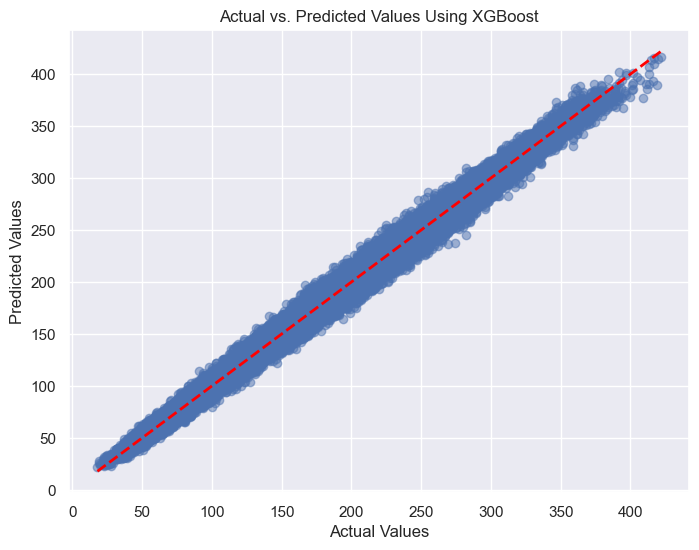

In [53]:
# visualize the predictions

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_XG, alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values Using XGBoost')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], linestyle='--', color='red', lw=2)
plt.show()


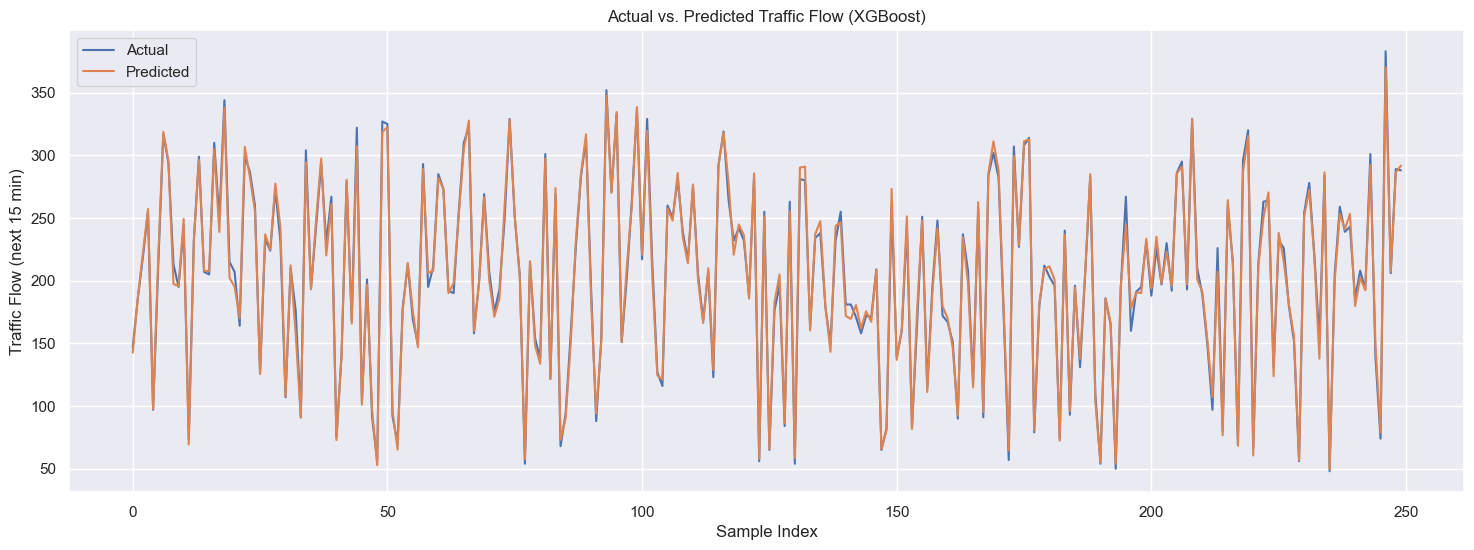

In [54]:
plt.figure(figsize=(18, 6))
start = 8000 if len(y_test) > 8250 else 0
end = min(start + 250, len(y_test))
plt.plot(y_test.iloc[start:end].to_numpy(), label='Actual')
plt.plot(y_pred_XG[start:end], label='Predicted')
plt.legend()
plt.title('Actual vs. Predicted Traffic Flow (XGBoost)')
plt.xlabel('Sample Index')
plt.ylabel('Traffic Flow (next 15 min)')
plt.show()

evaluation

In [55]:
# 加载 evaluation 数据集
eval_dataset_path = "Dataset/dataset_for_traffic_project_assignment/evaluation_dataset.csv"
df_eval = pd.read_csv(eval_dataset_path, sep=";")
print(f'Evaluation 数据集形状: {df_eval.shape}')
df_eval.info()

Evaluation 数据集形状: (803377, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 803377 entries, 0 to 803376
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   DP_ID         803377 non-null  int64  
 1   PORTAL        803377 non-null  object 
 2   Date          803377 non-null  int64  
 3   Time          803377 non-null  object 
 4   Interval_1    803377 non-null  int64  
 5   Interval_5    803377 non-null  int64  
 6   Interval_15   803377 non-null  int64  
 7   Interval_30   803377 non-null  int64  
 8   Interval_60   803377 non-null  int64  
 9   SPEED_MS_AVG  803377 non-null  float64
 10  FLOW          803348 non-null  float64
dtypes: float64(2), int64(7), object(2)
memory usage: 67.4+ MB


In [56]:
# 对 evaluation 数据集进行与训练集相同的预处理
df_eval_processed = df_eval.copy()

# 日期和时间处理
if not pd.api.types.is_datetime64_any_dtype(df_eval_processed['Date']):
    df_eval_processed['Date'] = pd.to_datetime(df_eval_processed['Date'].astype(str), format='%Y%m%d')

time_dt = pd.to_datetime(df_eval_processed['Time'], format='%H:%M:%S')
df_eval_processed['Day'] = df_eval_processed['Date'].dt.day_name()
df_eval_processed['Month'] = df_eval_processed['Date'].dt.month_name()
df_eval_processed['Hour'] = time_dt.dt.hour
df_eval_processed['Minute'] = time_dt.dt.minute
df_eval_processed['Minute_Of_Day'] = df_eval_processed['Hour'] * 60 + df_eval_processed['Minute']

# 创建映射特征
df_eval_processed['Day_ID'] = df_eval_processed['Day'].map(day_mapping)
df_eval_processed['Month_ID'] = df_eval_processed['Month'].map(month_mapping)
df_eval_processed['Is_Weekend'] = df_eval_processed['Day_ID'].isin([6, 7]).astype(int)
df_eval_processed['Is_Peak_Morning'] = df_eval_processed['Minute_Of_Day'].between(7 * 60 + 30, 8 * 60 + 30).astype(int)
df_eval_processed['Daily_Sin'] = np.sin(2 * np.pi * df_eval_processed['Minute_Of_Day'] / 1440.0)
df_eval_processed['Daily_Cos'] = np.cos(2 * np.pi * df_eval_processed['Minute_Of_Day'] / 1440.0)

# 创建Portal相关特征 (与训练集保持一致)
portal_numbers = df_eval_processed['PORTAL'].astype(str).str.extract(r'(\d+[\.,]?\d*)', expand=False)
portal_numbers = portal_numbers.str.replace('[^0-9]', '', regex=True)
df_eval_processed['Portal_Pos'] = pd.to_numeric(portal_numbers, errors='coerce')
df_eval_processed['Portal_Flow_Mean'] = df_eval_processed.groupby('PORTAL')['FLOW'].transform('mean')
df_eval_processed['Portal_Speed_Mean'] = df_eval_processed.groupby('PORTAL')['SPEED_MS_AVG'].transform('mean')

# 创建时间间隔特征
df_eval_processed['Interval_1'] = df_eval_processed['Minute_Of_Day']
df_eval_processed['Interval_5'] = (df_eval_processed['Minute_Of_Day'] // 5).astype(int)
df_eval_processed['Interval_15'] = (df_eval_processed['Minute_Of_Day'] // 15).astype(int)
df_eval_processed['Interval_30'] = (df_eval_processed['Minute_Of_Day'] // 30).astype(int)
df_eval_processed['Interval_60'] = (df_eval_processed['Minute_Of_Day'] // 60).astype(int)

# 添加DP_ID (如果训练集中有)
if 'DP_ID' not in df_eval_processed.columns:
    df_eval_processed['DP_ID'] = df_eval_processed['Day_ID']  # 简单映射

In [57]:
# 构建 evaluation 数据集的目标变量和特征工程
eval_base = df_eval_processed.sort_values(['PORTAL', 'Date', 'Minute_Of_Day']).copy()

# 创建未来15分钟的目标变量
eval_base['FLOW_NEXT_15'] = eval_base.groupby(['PORTAL', 'Date'])['FLOW'].transform(
    lambda s: s.shift(-1).rolling(window=15, min_periods=15).sum()
)

# 创建滞后特征
lag_steps = [1, 5, 10, 15]
for lag in lag_steps:
    eval_base[f'FLOW_LAG_{lag}'] = eval_base.groupby(['PORTAL', 'Date'])['FLOW'].shift(lag)
    eval_base[f'SPEED_LAG_{lag}'] = eval_base.groupby(['PORTAL', 'Date'])['SPEED_MS_AVG'].shift(lag)

# 创建滚动均值特征
rolling_windows = [5, 15]
for window in rolling_windows:
    eval_base[f'FLOW_ROLL_MEAN_{window}'] = eval_base.groupby(['PORTAL', 'Date'])['FLOW'].transform(
        lambda s: s.shift(1).rolling(window=window, min_periods=1).mean()
    )
    eval_base[f'SPEED_ROLL_MEAN_{window}'] = eval_base.groupby(['PORTAL', 'Date'])['SPEED_MS_AVG'].transform(
        lambda s: s.shift(1).rolling(window=window, min_periods=1).mean()
    )

# 删除不需要的列
columns_to_remove = ['Day', 'Month', 'Time', 'PORTAL']
eval_base = eval_base.drop(columns=[col for col in columns_to_remove if col in eval_base.columns])

# 筛选早高峰时段 (7:00-8:30)
peak_window_mask = (eval_base['Minute_Of_Day'] >= 7 * 60) & (eval_base['Minute_Of_Day'] <= 8 * 60 + 30)
eval_dataset = eval_base[peak_window_mask].copy()

# 删除包含 NaN 的行
required_for_supervision = ['FLOW_NEXT_15'] + [f'FLOW_LAG_{lag}' for lag in lag_steps] + [f'SPEED_LAG_{lag}' for lag in lag_steps]
eval_dataset = eval_dataset.dropna(subset=required_for_supervision)

eval_dataset.head()

,DP_ID,Date,Interval_1,Interval_5,Interval_15,Interval_30,Interval_60,SPEED_MS_AVG,FLOW,Hour,...,FLOW_LAG_5,SPEED_LAG_5,FLOW_LAG_10,SPEED_LAG_10,FLOW_LAG_15,SPEED_LAG_15,FLOW_ROLL_MEAN_5,SPEED_ROLL_MEAN_5,FLOW_ROLL_MEAN_15,SPEED_ROLL_MEAN_15
3699,1076,2022-01-01,420,84,28,14,7,18.60,2.0,7,...,4.0,22.08,3.0,19.73,3.0,19.90,3.0,19.766,2.733333,20.054667
3700,751,2022-01-01,420,84,28,14,7,22.65,2.0,7,...,3.0,16.00,1.0,17.20,4.0,23.53,2.6,19.070,2.666667,19.968000
3727,1076,2022-01-01,421,84,28,14,7,22.20,1.0,7,...,3.0,17.77,2.0,21.10,3.0,21.73,2.4,20.400,2.533333,19.909333
3728,751,2022-01-01,421,84,28,14,7,21.35,2.0,7,...,3.0,20.93,2.0,20.30,3.0,21.27,2.0,21.286,2.400000,19.940667
3733,1076,2022-01-01,422,84,28,14,7,20.55,2.0,7,...,2.0,22.05,2.0,18.90,3.0,18.33,1.8,21.370,2.333333,19.946000


In [58]:
# 准备 evaluation 数据集的特征和目标变量
feature_drop = ['FLOW_NEXT_15', 'FLOW_NEXT_30', 'FLOW_NEXT_60', 'Date']
X_eval = eval_dataset.drop(columns=[col for col in feature_drop if col in eval_dataset.columns])
y_eval = eval_dataset['FLOW_NEXT_15']

# 检查并处理 NaN 值
print(f'处理前 - X_eval 形状: {X_eval.shape}')
print(f'X_eval 中 NaN 值数量: {X_eval.isna().sum().sum()}')

# 删除包含 NaN 的行
valid_indices = ~(X_eval.isna().any(axis=1) | y_eval.isna())
X_eval = X_eval[valid_indices]
y_eval = y_eval[valid_indices]

print(f'\n处理后 - X_eval 形状: {X_eval.shape}')
print(f'y_eval 形状: {y_eval.shape}')
print(f'特征列: {X_eval.columns.tolist()}')

处理前 - X_eval 形状: (215679, 32)
X_eval 中 NaN 值数量: 189859

处理后 - X_eval 形状: (25820, 32)
y_eval 形状: (25820,)
特征列: ['DP_ID', 'Interval_1', 'Interval_5', 'Interval_15', 'Interval_30', 'Interval_60', 'SPEED_MS_AVG', 'FLOW', 'Hour', 'Minute', 'Minute_Of_Day', 'Day_ID', 'Month_ID', 'Is_Weekend', 'Is_Peak_Morning', 'Daily_Sin', 'Daily_Cos', 'Portal_Pos', 'Portal_Flow_Mean', 'Portal_Speed_Mean', 'FLOW_LAG_1', 'SPEED_LAG_1', 'FLOW_LAG_5', 'SPEED_LAG_5', 'FLOW_LAG_10', 'SPEED_LAG_10', 'FLOW_LAG_15', 'SPEED_LAG_15', 'FLOW_ROLL_MEAN_5', 'SPEED_ROLL_MEAN_5', 'FLOW_ROLL_MEAN_15', 'SPEED_ROLL_MEAN_15']


In [59]:
# 使用已训练的 XGBoost 模型在 evaluation 数据集上进行预测
y_pred_XG_eval = best_xgb.predict(X_eval)

# 计算评估指标
mae_xg_eval = mean_absolute_error(y_eval, y_pred_XG_eval)
mse_xg_eval = mean_squared_error(y_eval, y_pred_XG_eval)
rmse_xg_eval = np.sqrt(mse_xg_eval)
r2_xg_eval = r2_score(y_eval, y_pred_XG_eval)

print('='*50)
print('XGBoost 模型 - Evaluation 数据集性能')
print('='*50)
print(f'Mean Absolute Error (MAE):     {mae_xg_eval:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse_xg_eval:.4f}')
print(f'R-squared (R²):                 {r2_xg_eval:.4f}')
print('='*50)

XGBoost 模型 - Evaluation 数据集性能
Mean Absolute Error (MAE):     5.4923
Root Mean Squared Error (RMSE): 7.1174
R-squared (R²):                 0.9925


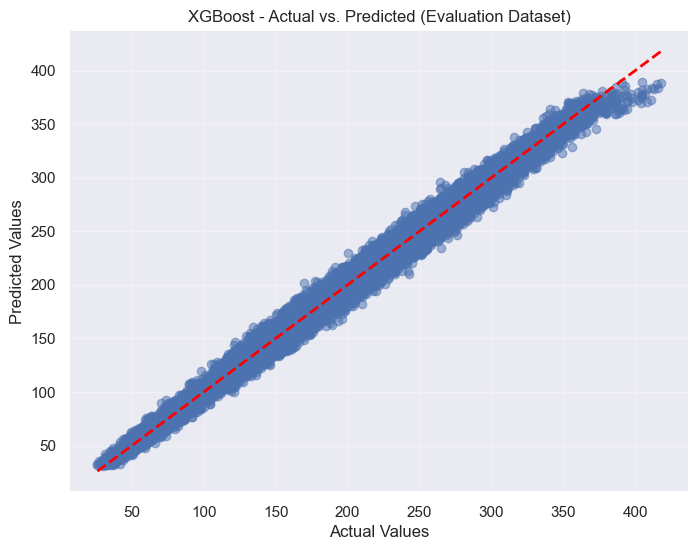

In [60]:
# 可视化 XGBoost 在 evaluation 数据集上的预测结果
plt.figure(figsize=(8, 6))
plt.scatter(y_eval, y_pred_XG_eval, alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('XGBoost - Actual vs. Predicted (Evaluation Dataset)')
plt.plot([y_eval.min(), y_eval.max()], [y_eval.min(), y_eval.max()], linestyle='--', color='red', lw=2)
plt.grid(True, alpha=0.3)
plt.show()

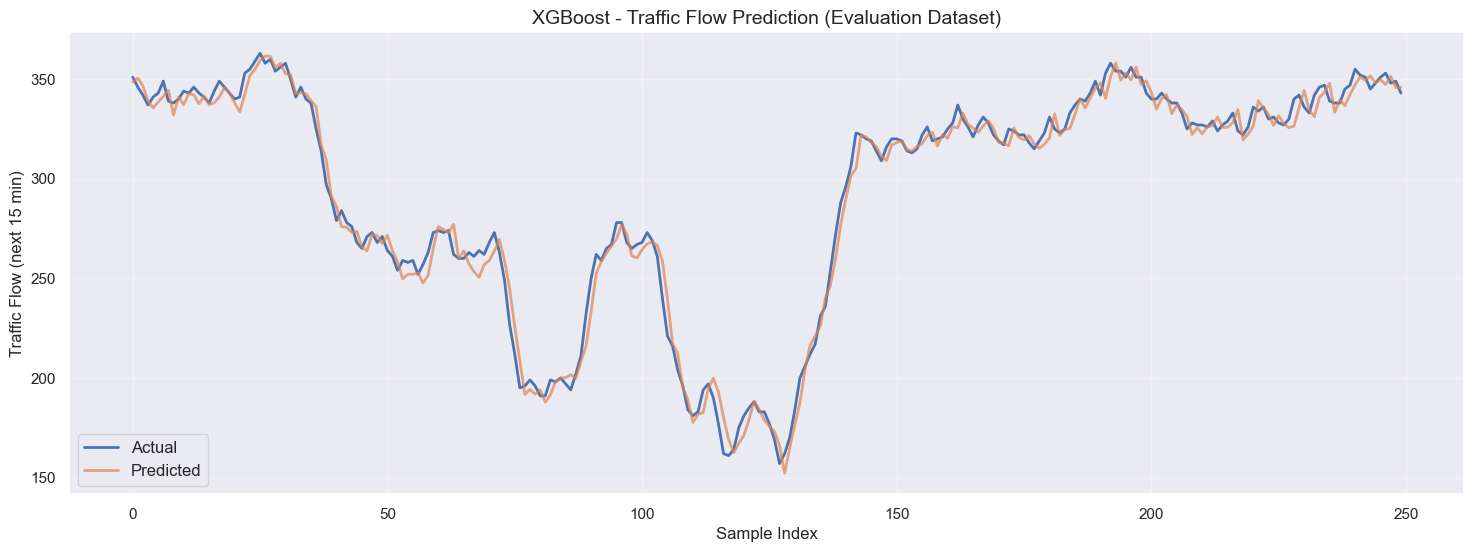

In [61]:
# 时间序列对比图 (XGBoost - Evaluation)
plt.figure(figsize=(18, 6))
start = 0
end = min(250, len(y_eval))
y_eval_array = y_eval.iloc[start:end].to_numpy()
plt.plot(y_eval_array, label='Actual', linewidth=2)
plt.plot(y_pred_XG_eval[start:end], label='Predicted', linewidth=2, alpha=0.7)
plt.legend(fontsize=12)
plt.title('XGBoost - Traffic Flow Prediction (Evaluation Dataset)', fontsize=14)
plt.xlabel('Sample Index', fontsize=12)
plt.ylabel('Traffic Flow (next 15 min)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

linear regression

In [62]:
from sklearn.linear_model import LinearRegression

LRmodel = LinearRegression()
LRmodel.fit(X_train, y_train)


,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [63]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_pred_LR = LRmodel.predict(X_test)
mae_LR = mean_absolute_error(y_test, y_pred_LR)
mse_LR = mean_squared_error(y_test, y_pred_LR)
rmse_LR = np.sqrt(mse_LR)
r2_LR = r2_score(y_test, y_pred_LR)
print(f'Mean Absolute Error: {mae_LR:.4f}')
print(f'Root Mean Squared Error: {rmse_LR:.4f}')
print(f'R-squared: {r2_LR:.4f}')


Mean Absolute Error: 5.8232
Root Mean Squared Error: 7.4639
R-squared: 0.9905


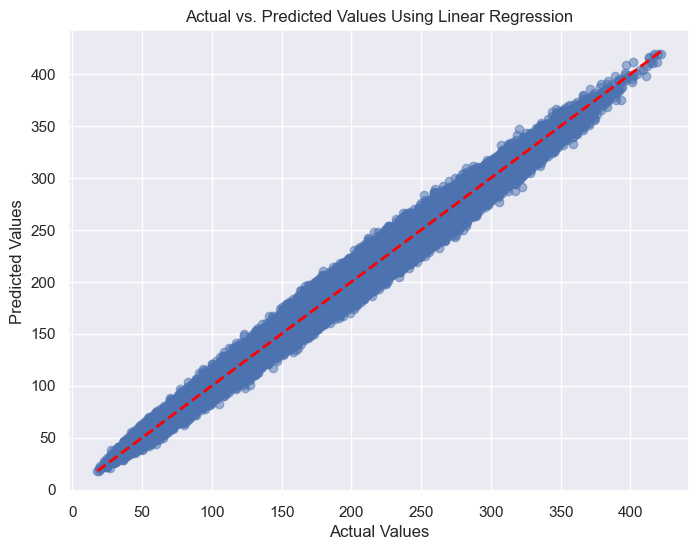

In [64]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_LR, alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values Using Linear Regression')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], linestyle='--', color='red', lw=2)
plt.show()


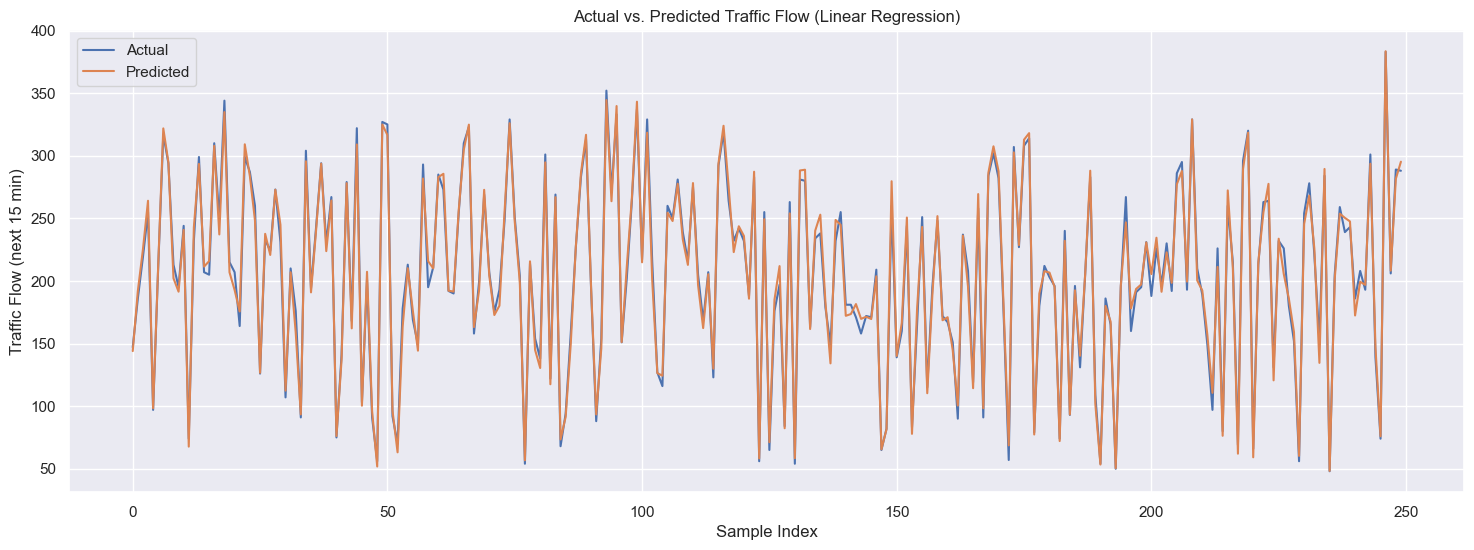

In [65]:
plt.figure(figsize=(18, 6))
start = 8000 if len(y_test) > 8250 else 0
end = min(start + 250, len(y_test))
plt.plot(y_test.iloc[start:end].to_numpy(), label='Actual')
plt.plot(y_pred_LR[start:end], label='Predicted')
plt.legend()
plt.title('Actual vs. Predicted Traffic Flow (Linear Regression)')
plt.xlabel('Sample Index')
plt.ylabel('Traffic Flow (next 15 min)')
plt.show()

evaluation

In [66]:
# 使用已训练的 Linear Regression 模型在 evaluation 数据集上进行预测
y_pred_LR_eval = LRmodel.predict(X_eval)

# 计算评估指标
mae_lr_eval = mean_absolute_error(y_eval, y_pred_LR_eval)
mse_lr_eval = mean_squared_error(y_eval, y_pred_LR_eval)
rmse_lr_eval = np.sqrt(mse_lr_eval)
r2_lr_eval = r2_score(y_eval, y_pred_LR_eval)

print('='*50)
print('Linear Regression 模型 - Evaluation 数据集性能')
print('='*50)
print(f'Mean Absolute Error (MAE):     {mae_lr_eval:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse_lr_eval:.4f}')
print(f'R-squared (R²):                 {r2_lr_eval:.4f}')
print('='*50)

Linear Regression 模型 - Evaluation 数据集性能
Mean Absolute Error (MAE):     5.6587
Root Mean Squared Error (RMSE): 7.2771
R-squared (R²):                 0.9922


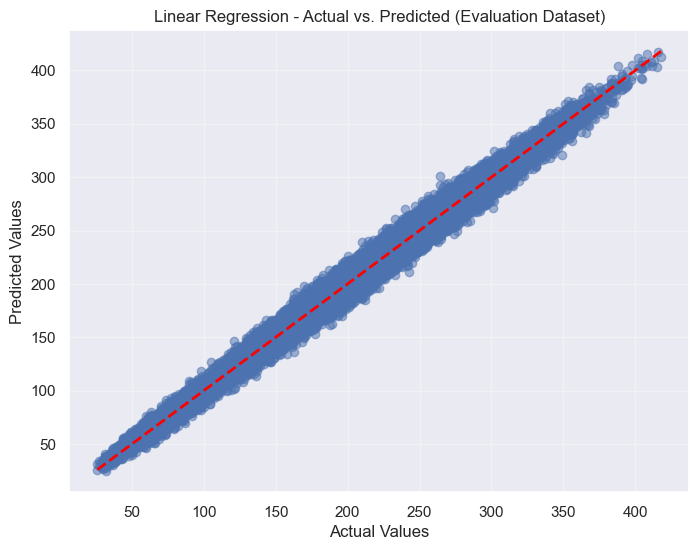

In [67]:
# 可视化 Linear Regression 在 evaluation 数据集上的预测结果
plt.figure(figsize=(8, 6))
plt.scatter(y_eval, y_pred_LR_eval, alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Linear Regression - Actual vs. Predicted (Evaluation Dataset)')
plt.plot([y_eval.min(), y_eval.max()], [y_eval.min(), y_eval.max()], linestyle='--', color='red', lw=2)
plt.grid(True, alpha=0.3)
plt.show()

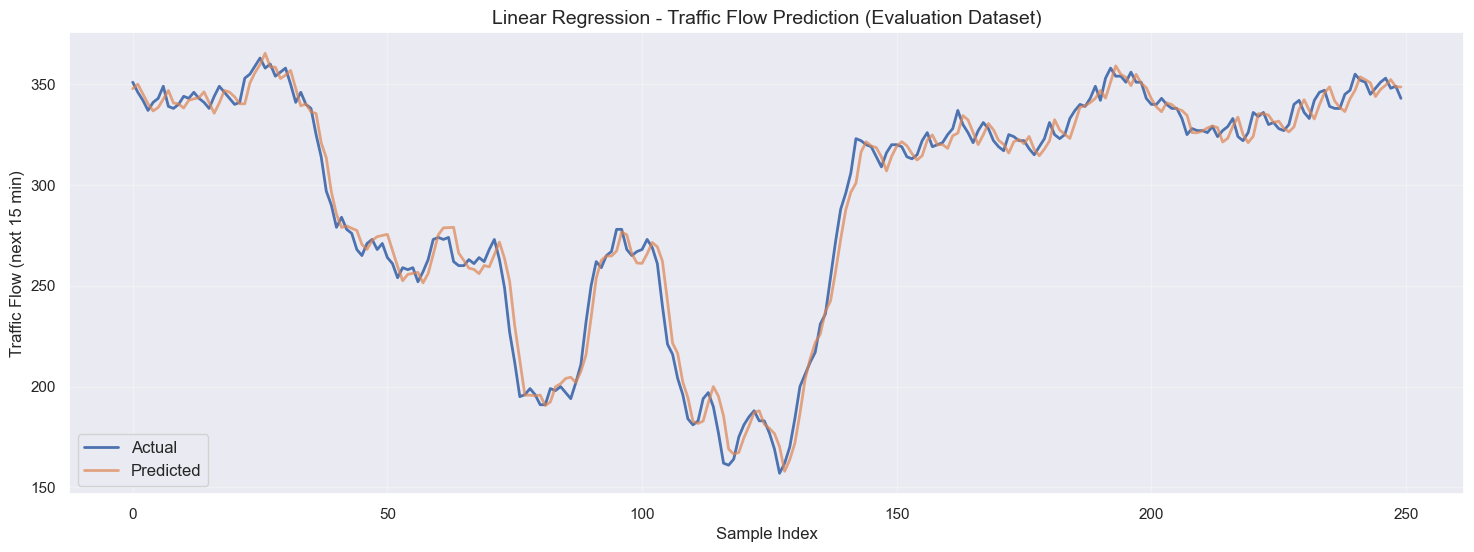

In [68]:
# 时间序列对比图 (Linear Regression - Evaluation)
plt.figure(figsize=(18, 6))
start = 0
end = min(250, len(y_eval))
y_eval_array = y_eval.iloc[start:end].to_numpy()
plt.plot(y_eval_array, label='Actual', linewidth=2)
plt.plot(y_pred_LR_eval[start:end], label='Predicted', linewidth=2, alpha=0.7)
plt.legend(fontsize=12)
plt.title('Linear Regression - Traffic Flow Prediction (Evaluation Dataset)', fontsize=14)
plt.xlabel('Sample Index', fontsize=12)
plt.ylabel('Traffic Flow (next 15 min)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

lstm

In [18]:
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# 排序，确保时间顺序
sort_columns = [col for col in ['Portal_Pos', 'Date', 'Minute_Of_Day'] if col in model_dataset.columns]
lstm_data = model_dataset.sort_values(sort_columns).reset_index(drop=True)

# 目标列与需要排除的列
target_col = 'FLOW_NEXT_15'
drop_cols = ['Date', 'FLOW_NEXT_30', 'FLOW_NEXT_60']

# 生成分钟周期编码（如果可用）
if 'Minute_Of_Day' in lstm_data.columns:
    angle = 2 * np.pi * (lstm_data['Minute_Of_Day'] % 1440) / 1440.0
    lstm_data = lstm_data.copy()
    lstm_data['Minute_Sin'] = np.sin(angle)
    lstm_data['Minute_Cos'] = np.cos(angle)

# LSTM 序列输入采用关键原始信号
seq_cols = [c for c in ['FLOW','SPEED_MS_AVG','Portal_Pos','Minute_Sin','Minute_Cos'] if c in lstm_data.columns]

# 宽特征按工程化前缀自动收集，并补充少量基础列
prefixes = ['FLOW_LAG_','SPEED_LAG_','FLOW_ROLL_MEAN_','SPEED_ROLL_MEAN_']
wide_cols = [c for c in lstm_data.columns if any(c.startswith(p) for p in prefixes)]
for c in ['FLOW','SPEED_MS_AVG','Portal_Pos','Minute_Sin','Minute_Cos']:
    if c in lstm_data.columns and c not in wide_cols:
        wide_cols.append(c)
# 去重保持顺序
wide_cols = list(dict.fromkeys(wide_cols))

# 仅对用到的列做缺失值与标准化
imputer = SimpleImputer(strategy='median')
lstm_data_clean = lstm_data.copy()
if seq_cols:
    lstm_data_clean[seq_cols] = imputer.fit_transform(lstm_data[seq_cols])
if wide_cols:
    lstm_data_clean[wide_cols] = imputer.fit_transform(lstm_data[wide_cols])

scaler_seq = StandardScaler()
feature_values = scaler_seq.fit_transform(lstm_data_clean[seq_cols]) if seq_cols else np.empty((len(lstm_data_clean),0))

scaler_wide = StandardScaler()
wide_values = scaler_wide.fit_transform(lstm_data_clean[wide_cols]) if wide_cols else np.empty((len(lstm_data_clean),0))

# 目标标准化
target_values = lstm_data_clean[target_col].to_numpy().reshape(-1,1)
target_scaler_lstm = StandardScaler()
target_values_scaled = target_scaler_lstm.fit_transform(target_values)

# 窗口长度（短窗更稳）
sequence_length = 16

# 记录列名，便于排查
lstm_feature_columns = seq_cols
wide_feature_columns = wide_cols


In [19]:
X_seq, X_wide_list, y_seq_scaled, y_seq_actual = [], [], [], []

# 分组（如可用）
group_keys = []
if 'Portal_Pos' in lstm_data_clean.columns:
    lstm_data_clean['Portal_Group'] = lstm_data_clean['Portal_Pos'].fillna(-1)
    group_keys.append('Portal_Group')
if 'Date' in lstm_data_clean.columns:
    group_keys.append('Date')

groups_iter = lstm_data_clean.groupby(group_keys, dropna=False) if group_keys else [(None, lstm_data_clean)]

for _, group in groups_iter:
    group_sorted = group.sort_values('Minute_Of_Day') if 'Minute_Of_Day' in group.columns else group
    idxs = group_sorted.index.to_numpy()
    if len(idxs) <= sequence_length:
        continue
    for start in range(len(idxs) - sequence_length):
        window_idx = idxs[start:start + sequence_length]
        target_idx = idxs[start + sequence_length]
        X_seq.append(feature_values[window_idx])
        X_wide_list.append(wide_values[target_idx])
        y_seq_scaled.append(target_values_scaled[target_idx,0])
        y_seq_actual.append(lstm_data_clean[target_col].iloc[target_idx])

X_seq = np.array(X_seq, dtype=np.float32)
X_wide = np.array(X_wide_list, dtype=np.float32)
y_seq_scaled = np.array(y_seq_scaled, dtype=np.float32)
y_seq_actual = np.array(y_seq_actual, dtype=np.float32)

# 去除 NaN 样本
if (np.isnan(X_seq).any() or np.isnan(y_seq_scaled).any() or np.isnan(X_wide).any()):
    valid_indices = ~(np.isnan(X_seq).any(axis=(1,2)) | np.isnan(y_seq_scaled) | np.isnan(X_wide).any(axis=1))
    X_seq = X_seq[valid_indices]
    X_wide = X_wide[valid_indices]
    y_seq_scaled = y_seq_scaled[valid_indices]
    y_seq_actual = y_seq_actual[valid_indices]

# 时间顺序切分
split_index = int(len(X_seq) * 0.8)
X_train_lstm = X_seq[:split_index]
X_test_lstm = X_seq[split_index:]
X_train_wide = X_wide[:split_index]
X_test_wide = X_wide[split_index:]
y_train_scaled_lstm = y_seq_scaled[:split_index]
y_test_scaled_lstm = y_seq_scaled[split_index:]
y_test_actual_lstm = y_seq_actual[split_index:]


In [20]:
import os
import tensorflow as tf

tf.keras.utils.disable_interactive_logging()
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
lstm_device = '/GPU:0' if gpus else '/CPU:0'

l2_reg = tf.keras.regularizers.l2(1e-5)

with tf.device(lstm_device):
    seq_in = tf.keras.layers.Input(shape=(sequence_length, X_train_lstm.shape[-1]), name='seq_input')
    wide_in = tf.keras.layers.Input(shape=(X_train_wide.shape[-1],), name='wide_input')

    # LSTM 残差支路
    x = tf.keras.layers.LayerNormalization()(seq_in)
    x = tf.keras.layers.LSTM(16, dropout=0.1, name='lstm16')(x)
    x = tf.keras.layers.Dense(8, activation='swish', kernel_regularizer=l2_reg)(x)
    residual = tf.keras.layers.Dense(1, name='residual')(x)

    # 宽线性支路（等价线性回归）
    wide_linear = tf.keras.layers.Dense(1, use_bias=True, name='wide_linear')(wide_in)

    y_hat = tf.keras.layers.Add(name='y_hat')([wide_linear, residual])
    lstm_model = tf.keras.Model(inputs=[seq_in, wide_in], outputs=y_hat, name='WideLSTM')
    optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4, clipnorm=1.0)
    lstm_model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

lstm_model_params = lstm_model.count_params()


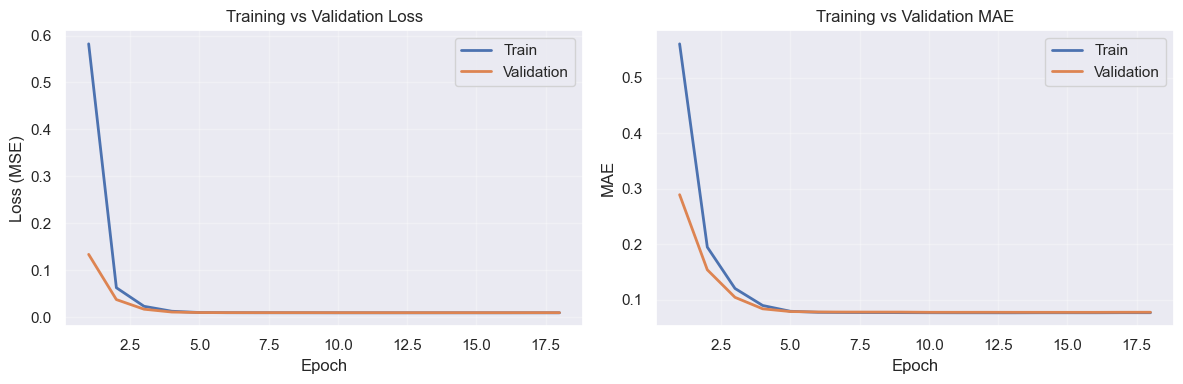

In [21]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=5e-5
)

with tf.device(lstm_device):
    history = lstm_model.fit(
        [X_train_lstm, X_train_wide],
        y_train_scaled_lstm,
        validation_split=0.2,
        epochs=50,
        batch_size=256,
        shuffle=False,
        verbose=2,
        callbacks=[early_stopping, reduce_lr]
    )

history_epochs = range(1, len(history.history['loss']) + 1)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(history_epochs, history.history['loss'], label='Train', linewidth=2)
axes[0].plot(history_epochs, history.history['val_loss'], label='Validation', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (MSE)')
axes[0].set_title('Training vs Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history_epochs, history.history['mae'], label='Train', linewidth=2)
axes[1].plot(history_epochs, history.history['val_mae'], label='Validation', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('MAE')
axes[1].set_title('Training vs Validation MAE')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

lstm_training_stats = {
    'epochs_run': len(history.history['loss']),
    'best_epoch': int(np.argmin(history.history['val_loss'])) + 1,
    'best_val_loss': float(np.min(history.history['val_loss'])),
    'final_train_loss': float(history.history['loss'][-1]),
    'final_val_loss': float(history.history['val_loss'][-1])
}


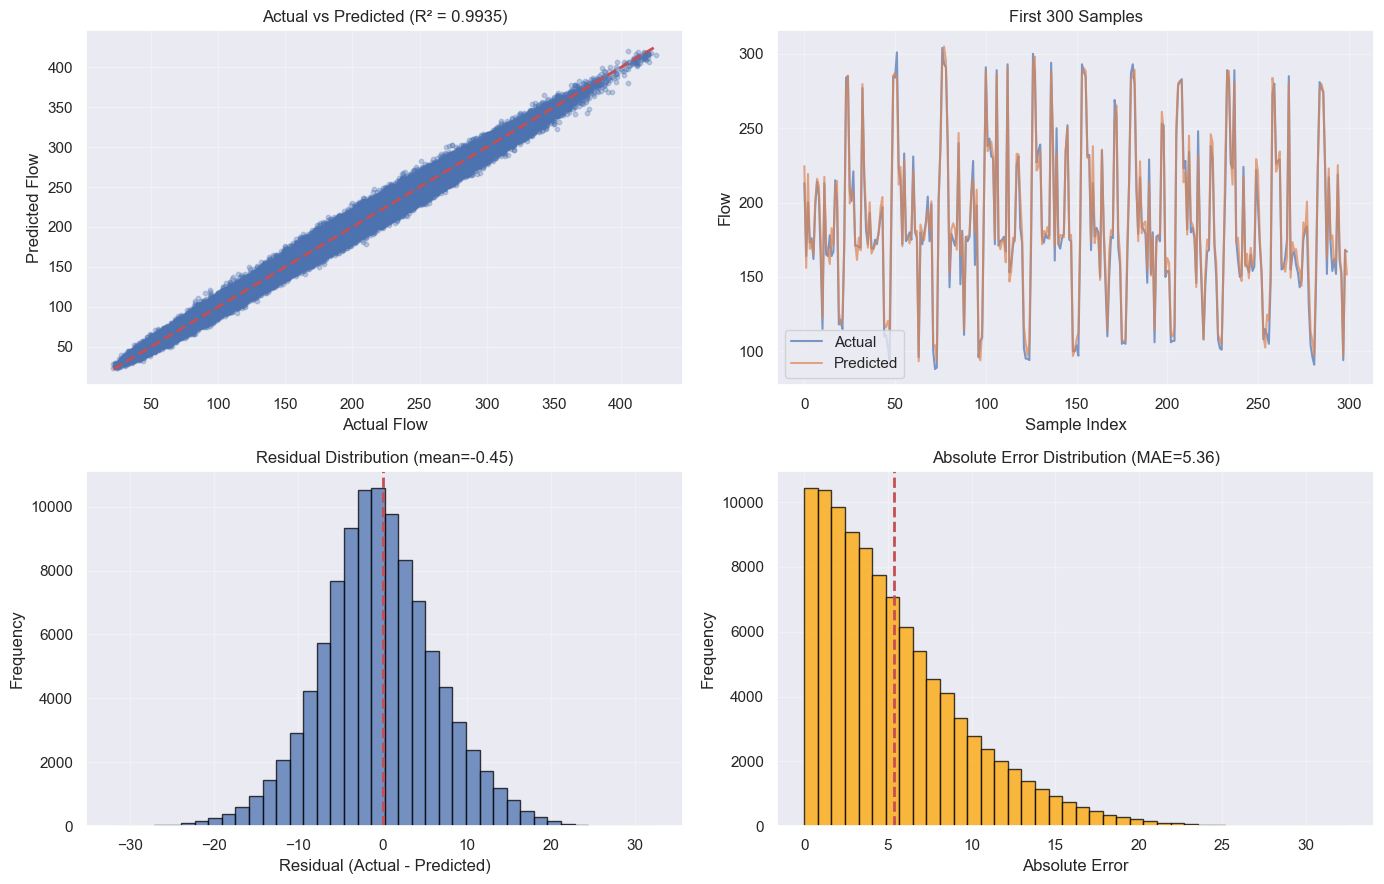

In [22]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

with tf.device(lstm_device):
    y_pred_scaled_lstm = lstm_model.predict([X_test_lstm, X_test_wide], verbose=0)

y_pred_lstm = target_scaler_lstm.inverse_transform(y_pred_scaled_lstm)
y_test_original_lstm = target_scaler_lstm.inverse_transform(y_test_scaled_lstm.reshape(-1, 1))

mae_lstm = mean_absolute_error(y_test_original_lstm, y_pred_lstm)
mse_lstm = mean_squared_error(y_test_original_lstm, y_pred_lstm)
rmse_lstm = float(np.sqrt(mse_lstm))
r2_lstm = r2_score(y_test_original_lstm, y_pred_lstm)

lstm_metrics = {
    'mae': float(mae_lstm),
    'mse': float(mse_lstm),
    'rmse': float(rmse_lstm),
    'r2': float(r2_lstm)
}

residuals = y_test_original_lstm.flatten() - y_pred_lstm.flatten()
abs_errors = np.abs(residuals)

fig, axes = plt.subplots(2, 2, figsize=(14, 9))
axes[0, 0].scatter(y_test_original_lstm, y_pred_lstm, alpha=0.3, s=10)
axes[0, 0].plot([y_test_original_lstm.min(), y_test_original_lstm.max()],
                [y_test_original_lstm.min(), y_test_original_lstm.max()],
                'r--', lw=2)
axes[0, 0].set_xlabel('Actual Flow')
axes[0, 0].set_ylabel('Predicted Flow')
axes[0, 0].set_title(f'Actual vs Predicted (R² = {r2_lstm:.4f})')
axes[0, 0].grid(True, alpha=0.3)

sample_limit = min(300, len(y_test_original_lstm))
axes[0, 1].plot(y_test_original_lstm[:sample_limit], label='Actual', linewidth=1.5, alpha=0.7)
axes[0, 1].plot(y_pred_lstm[:sample_limit], label='Predicted', linewidth=1.5, alpha=0.7)
axes[0, 1].set_xlabel('Sample Index')
axes[0, 1].set_ylabel('Flow')
axes[0, 1].set_title(f'First {sample_limit} Samples')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].legend()

axes[1, 0].hist(residuals, bins=40, edgecolor='black', alpha=0.75)
axes[1, 0].axvline(0, color='r', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Residual (Actual - Predicted)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title(f'Residual Distribution (mean={residuals.mean():.2f})')
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].hist(abs_errors, bins=40, edgecolor='black', alpha=0.75, color='orange')
axes[1, 1].axvline(mae_lstm, color='r', linestyle='--', linewidth=2)
axes[1, 1].set_xlabel('Absolute Error')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title(f'Absolute Error Distribution (MAE={mae_lstm:.2f})')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [23]:
print(f"mae: {lstm_metrics['mae']:.4f}")
print(f"rmse: {lstm_metrics['rmse']:.4f}")
print(f"r2: {lstm_metrics['r2']:.4f}")

mae: 5.3646
rmse: 6.8833
r2: 0.9935


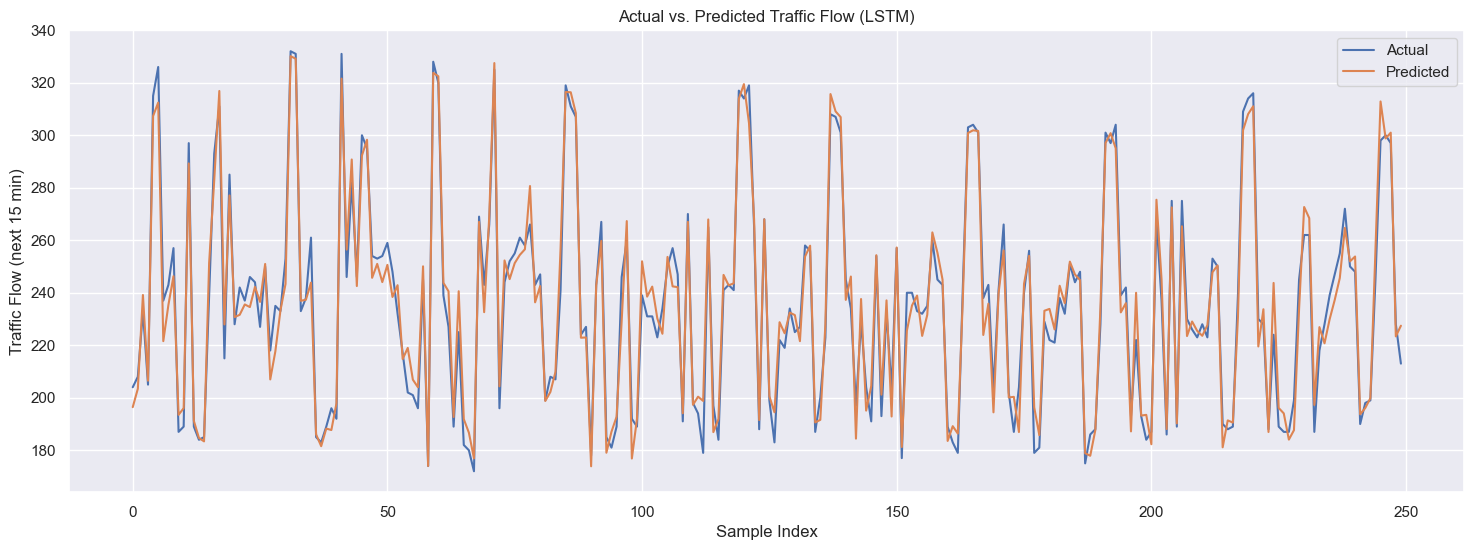

In [24]:
plt.figure(figsize=(18, 6))
n = len(y_test_original_lstm)
start = 8000 if n > 8250 else 0
end = min(start + 250, n)
plt.plot(y_test_original_lstm[start:end], label='Actual')
plt.plot(y_pred_lstm[start:end], label='Predicted')
plt.legend()
plt.title('Actual vs. Predicted Traffic Flow (LSTM)')
plt.xlabel('Sample Index')
plt.ylabel('Traffic Flow (next 15 min)')
plt.show()

all day data lstm

In [87]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf

ALLDAY_DIR = r'Dataset/dataset_for_traffic_project_assignment_ALLday'
train_csv = f'{ALLDAY_DIR}/training_dataset.csv'
all_df = pd.read_csv(train_csv, sep=';')
# 解析时间
all_df['Date'] = all_df['Date'].astype(str)
# Time -> 分钟
t = pd.to_datetime(all_df['Time']).dt
all_df['Minute_Of_Day'] = t.hour*60 + t.minute
# 日内周期
angle = 2*np.pi* (all_df['Minute_Of_Day']%1440)/1440.0
all_df['Minute_Sin'] = np.sin(angle)
all_df['Minute_Cos'] = np.cos(angle)
# 门户ID
all_df['Portal_ID'] = all_df['PORTAL'].astype('category').cat.codes

# 目标：FLOW_NEXT_15（组内按时间排序 shift(-15)）
all_df = all_df.sort_values(['PORTAL','Date','Minute_Of_Day'])
all_df['FLOW_NEXT_15'] = all_df.groupby(['PORTAL','Date'], dropna=False)['FLOW'].shift(-15)
# 与目标对齐的分钟（用于早高峰过滤）
all_df['Target_Minute'] = all_df.groupby(['PORTAL','Date'], dropna=False)['Minute_Of_Day'].shift(-15)
all_df = all_df.dropna(subset=['FLOW_NEXT_15']).reset_index(drop=True)

# 序列特征（每步）
seq_cols = [c for c in ['FLOW','SPEED_MS_AVG','Portal_ID','Minute_Sin','Minute_Cos'] if c in all_df.columns]

# 缺失填补与标准化
from sklearn.impute import SimpleImputer
imp = SimpleImputer(strategy='median')
all_df[seq_cols] = imp.fit_transform(all_df[seq_cols])

scaler_x = StandardScaler().fit(all_df[seq_cols])
X_all = scaler_x.transform(all_df[seq_cols]).astype(np.float32)
scaler_y = StandardScaler().fit(all_df[['FLOW_NEXT_15']])
y_all = scaler_y.transform(all_df[['FLOW_NEXT_15']]).astype(np.float32).ravel()

seq_len = 16
X_seq, y_seq, tgt_min = [], [], []
for _, g in all_df.groupby(['PORTAL','Date'], dropna=False):
    idxs = g.index.to_numpy()
    vals = X_all[idxs]
    yy = y_all[idxs]
    target_mins = g['Target_Minute'].to_numpy()
    if len(g) <= seq_len: continue
    for s in range(len(g)-seq_len):
        X_seq.append(vals[s:s+seq_len])
        y_seq.append(yy[s+seq_len-1])
        tgt_min.append(target_mins[s+seq_len-1])

X_seq = np.asarray(X_seq, dtype=np.float32)
y_seq = np.asarray(y_seq, dtype=np.float32)
tgt_min = np.asarray(tgt_min, dtype=np.float32)
print('序列样本数:', len(X_seq), '输入形状:', X_seq.shape[1:])

# 基于目标分钟排序切分（近似时间顺序）
order_idx = np.argsort(tgt_min)
split = int(0.8 * len(X_seq))
train_idx, test_idx = order_idx[:split], order_idx[split:]
X_tr, X_te = X_seq[train_idx], X_seq[test_idx]
y_tr, y_te = y_seq[train_idx], y_seq[test_idx]

C:\Users\stan\AppData\Local\Temp\ipykernel_7900\2629238696.py:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  t = pd.to_datetime(all_df['Time']).dt


序列样本数: 7417887 输入形状: (16, 5)


In [ ]:
# === 全天 LSTM：再次训练并输出“整体 + 早高峰”评估（健壮版） ===
import numpy as np
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 依赖于上一单元（ALLday 预处理与切分）生成的变量：X_tr, X_te, y_tr, y_te, scaler_y, tgt_min, test_idx
for v in ['X_tr','X_te','y_tr','y_te','scaler_y','tgt_min','test_idx']:
    if v not in globals():
        raise RuntimeError('未找到依赖变量 %s，请先运行上一个“全天数据：加载与预处理 + 训练纯 LSTM（全天）”单元。' % v)

# 训练模型
tf.keras.utils.disable_interactive_logging()
import os; os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

with tf.device('/GPU:0' if tf.config.list_physical_devices('GPU') else '/CPU:0'):
    allday_model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(X_tr.shape[1], X_tr.shape[2])),
        tf.keras.layers.LSTM(32, return_sequences=True),
        tf.keras.layers.LayerNormalization(),
        tf.keras.layers.LSTM(16),
        tf.keras.layers.Dense(16, activation='swish'),
        tf.keras.layers.Dense(1)
    ])
    allday_model.compile(optimizer=tf.keras.optimizers.Adam(5e-4), loss='mse', metrics=['mae'])

    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
    rlrop = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=5e-5)

    hist2 = allday_model.fit(X_tr, y_tr, validation_split=0.2, epochs=30, batch_size=256, shuffle=False,
                             callbacks=[es, rlrop], verbose=2)

# 预测并逆标准化
y_pred_te = allday_model.predict(X_te, verbose=0).ravel()
y_te_inv = scaler_y.inverse_transform(y_te.reshape(-1,1)).ravel()
y_pred_inv = scaler_y.inverse_transform(y_pred_te.reshape(-1,1)).ravel()

from math import sqrt
mae_all = mean_absolute_error(y_te_inv, y_pred_inv)
rmse_all = sqrt(mean_squared_error(y_te_inv, y_pred_inv))
r2_all = r2_score(y_te_inv, y_pred_inv)
print(f'全天训练，整体评估 -> MAE={mae_all:.4f} RMSE={rmse_all:.4f} R²={r2_all:.4f}')

# 仅在“早高峰”目标分钟（7:00–8:30）评估（若该时段样本为空则跳过）
peak_mask = (tgt_min[test_idx] >= 7*60) & (tgt_min[test_idx] <= 8*60 + 30)
peak_n = int(peak_mask.sum())
if peak_n > 0:
    mae_peak = mean_absolute_error(y_te_inv[peak_mask], y_pred_inv[peak_mask])
    rmse_peak = sqrt(mean_squared_error(y_te_inv[peak_mask], y_pred_inv[peak_mask]))
    r2_peak = r2_score(y_te_inv[peak_mask], y_pred_inv[peak_mask])
    print(f'全天训练，早高峰评估 -> MAE={mae_peak:.4f} RMSE={rmse_peak:.4f} R²={r2_peak:.4f} (样本数={peak_n})')
else:
    print('提示：当前测试切分未包含早高峰样本（7:00–8:30')


SyntaxError: invalid character '）' (U+FF09) (4008697739.py, line 52)

In [ ]:
# === 全天 LSTM：训练曲线与简单可视化 ===
import matplotlib.pyplot as plt

# 训练曲线
d = hist2.history if 'hist2' in globals() else {}
train_loss = d.get('loss', [])
val_loss = d.get('val_loss', [])
train_mae = d.get('mae', d.get('mean_absolute_error', []))
val_mae = d.get('val_mae', d.get('val_mean_absolute_error', []))

fig, axes = plt.subplots(1, 2, figsize=(12,4))
axes[0].plot(train_loss, label='Train Loss', lw=2)
axes[0].plot(val_loss, label='Val Loss', lw=2)
axes[0].set_title('Loss'); axes[0].set_xlabel('Epoch'); axes[0].grid(True, alpha=0.3); axes[0].legend()

axes[1].plot(train_mae, label='Train MAE', lw=2)
axes[1].plot(val_mae, label='Val MAE', lw=2)
axes[1].set_title('MAE'); axes[1].set_xlabel('Epoch'); axes[1].grid(True, alpha=0.3); axes[1].legend()
plt.tight_layout(); plt.show()

# 简单可视化：测试集前若干点的实际 vs 预测
if 'y_te_inv' in globals() and 'y_pred_inv' in globals():
    m = min(300, len(y_te_inv))
    plt.figure(figsize=(12,3))
    plt.plot(y_te_inv[:m], label='Actual', alpha=0.8)
    plt.plot(y_pred_inv[:m], label='Predicted', alpha=0.8)
    plt.title(f'Test First {m} Samples')
    plt.xlabel('Index'); plt.ylabel('Flow'); plt.grid(True, alpha=0.3); plt.legend(); plt.show()


In [ ]:
# === 全天 LSTM：结果直观展示（整体 + 早高峰） ===
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt

# 依赖于上一单元：y_te_inv, y_pred_inv
if 'y_te_inv' not in globals() or 'y_pred_inv' not in globals():
    raise RuntimeError('请先运行上一单元（全天 LSTM 评估），以生成 y_te_inv 与 y_pred_inv。')

# 重新计算整体指标以便展示
mae_all_v = mean_absolute_error(y_te_inv, y_pred_inv)
rmse_all_v = sqrt(mean_squared_error(y_te_inv, y_pred_inv))
r2_all_v = r2_score(y_te_inv, y_pred_inv)
residuals_all = y_te_inv - y_pred_inv
abs_all = np.abs(residuals_all)

print(f'整体 -> MAE={mae_all_v:.4f} RMSE={rmse_all_v:.4f} R²={r2_all_v:.4f}')

# 可视化：整体（2x2）
fig, axes = plt.subplots(2, 2, figsize=(14, 9))
# 1) 散点
axes[0,0].scatter(y_te_inv, y_pred_inv, alpha=0.3, s=10)
mn, mx = float(np.min(y_te_inv)), float(np.max(y_te_inv))
axes[0,0].plot([mn, mx], [mn, mx], 'r--', lw=2)
axes[0,0].set_title(f'整体: 实际 vs 预测 (R²={r2_all_v:.4f})')
axes[0,0].set_xlabel('实际'); axes[0,0].set_ylabel('预测'); axes[0,0].grid(True, alpha=0.3)
# 2) 前若干样本曲线
m = min(500, len(y_te_inv))
axes[0,1].plot(y_te_inv[:m], label='实际', lw=1.5, alpha=0.8)
axes[0,1].plot(y_pred_inv[:m], label='预测', lw=1.5, alpha=0.8)
axes[0,1].set_title(f'整体: 前 {m} 个样本')
axes[0,1].set_xlabel('索引'); axes[0,1].set_ylabel('流量'); axes[0,1].legend(); axes[0,1].grid(True, alpha=0.3)
# 3) 残差直方图
axes[1,0].hist(residuals_all, bins=50, edgecolor='black', alpha=0.75)
axes[1,0].axvline(0, color='r', linestyle='--', lw=2)
axes[1,0].set_title(f'整体: 残差分布 (均值={np.mean(residuals_all):.2f})')
axes[1,0].set_xlabel('残差(实际-预测)'); axes[1,0].set_ylabel('频数'); axes[1,0].grid(True, alpha=0.3)
# 4) 绝对误差直方图
axes[1,1].hist(abs_all, bins=50, edgecolor='black', alpha=0.75, color='orange')
axes[1,1].axvline(mae_all_v, color='r', linestyle='--', lw=2, label=f'MAE={mae_all_v:.2f}')
axes[1,1].set_title('整体: 绝对误差分布')
axes[1,1].set_xlabel('绝对误差'); axes[1,1].set_ylabel('频数'); axes[1,1].legend(); axes[1,1].grid(True, alpha=0.3)
plt.tight_layout(); plt.show()

# 早高峰评估（若可用）
peak_mask = None
if 'tgt_min' in globals() and 'test_idx' in globals():
    peak_mask = (tgt_min[test_idx] >= 7*60) & (tgt_min[test_idx] <= 8*60 + 30)

if peak_mask is not None and int(np.sum(peak_mask)) > 0:
    y_true_pk = y_te_inv[peak_mask]
    y_pred_pk = y_pred_inv[peak_mask]
    mae_pk = mean_absolute_error(y_true_pk, y_pred_pk)
    rmse_pk = sqrt(mean_squared_error(y_true_pk, y_pred_pk))
    r2_pk = r2_score(y_true_pk, y_pred_pk)
    res_pk = y_true_pk - y_pred_pk
    abs_pk = np.abs(res_pk)
    print(f'早高峰 -> MAE={mae_pk:.4f} RMSE={rmse_pk:.4f} R²={r2_pk:.4f} (样本数={int(np.sum(peak_mask))})')

    fig, axes = plt.subplots(2, 2, figsize=(14, 9))
    # 1) 散点
    axes[0,0].scatter(y_true_pk, y_pred_pk, alpha=0.3, s=10)
    mn, mx = float(np.min(y_true_pk)), float(np.max(y_true_pk))
    axes[0,0].plot([mn, mx], [mn, mx], 'r--', lw=2)
    axes[0,0].set_title(f'早高峰: 实际 vs 预测 (R²={r2_pk:.4f})')
    axes[0,0].set_xlabel('实际'); axes[0,0].set_ylabel('预测'); axes[0,0].grid(True, alpha=0.3)
    # 2) 前若干样本曲线
    m2 = min(500, len(y_true_pk))
    axes[0,1].plot(y_true_pk[:m2], label='实际', lw=1.5, alpha=0.8)
    axes[0,1].plot(y_pred_pk[:m2], label='预测', lw=1.5, alpha=0.8)
    axes[0,1].set_title(f'早高峰: 前 {m2} 个样本')
    axes[0,1].set_xlabel('索引'); axes[0,1].set_ylabel('流量'); axes[0,1].legend(); axes[0,1].grid(True, alpha=0.3)
    # 3) 残差直方图
    axes[1,0].hist(res_pk, bins=50, edgecolor='black', alpha=0.75)
    axes[1,0].axvline(0, color='r', linestyle='--', lw=2)
    axes[1,0].set_title(f'早高峰: 残差分布 (均值={np.mean(res_pk):.2f})')
    axes[1,0].set_xlabel('残差(实际-预测)'); axes[1,0].set_ylabel('频数'); axes[1,0].grid(True, alpha=0.3)
    # 4) 绝对误差直方图
    axes[1,1].hist(abs_pk, bins=50, edgecolor='black', alpha=0.75, color='orange')
    axes[1,1].axvline(mae_pk, color='r', linestyle='--', lw=2, label=f'MAE={mae_pk:.2f}')
    axes[1,1].set_title('早高峰: 绝对误差分布')
    axes[1,1].set_xlabel('绝对误差'); axes[1,1].set_ylabel('频数'); axes[1,1].legend(); axes[1,1].grid(True, alpha=0.3)
    plt.tight_layout(); plt.show()
else:
    print('提示：当前测试切分未包含早高峰样本，已跳过早高峰可视化。')


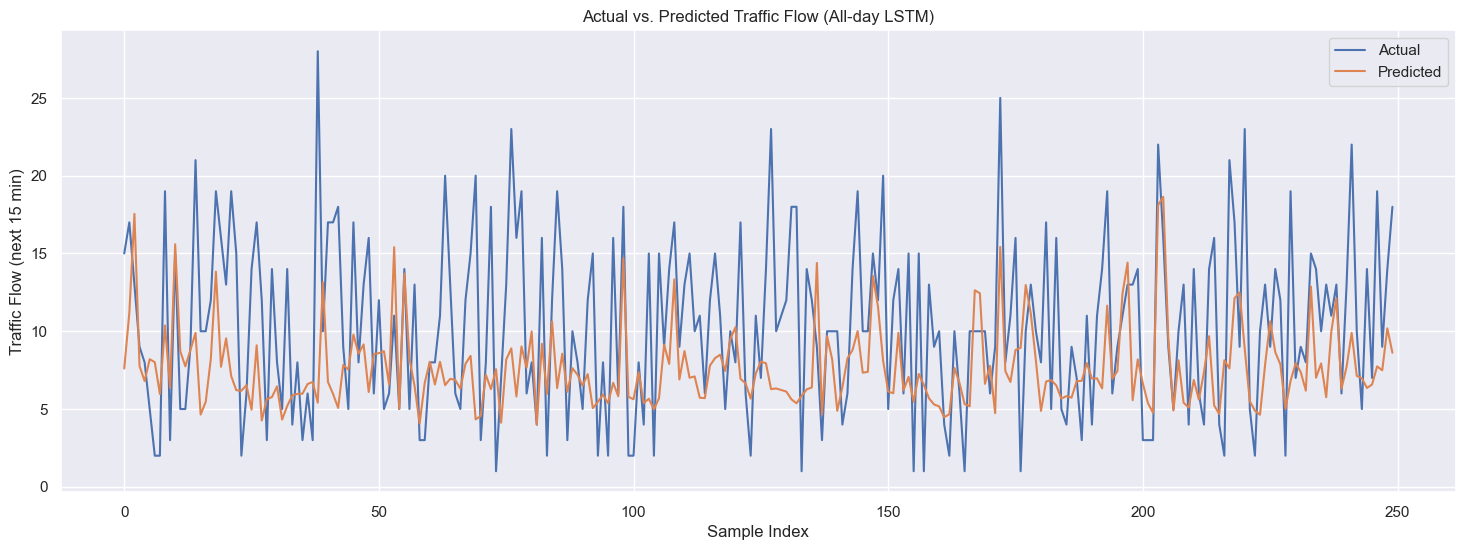

In [99]:
plt.figure(figsize=(18, 6))
n = len(y_te_inv)
start = 8000 if n > 8250 else 0
end = min(start + 250, n)
plt.plot(y_te_inv[start:end], label='Actual')
plt.plot(y_pred_inv[start:end], label='Predicted')
plt.legend()
plt.title('Actual vs. Predicted Traffic Flow (All-day LSTM)')
plt.xlabel('Sample Index')
plt.ylabel('Traffic Flow (next 15 min)')
plt.show()

In [ ]:
eval_allday_csv = f'{ALLDAY_DIR}/evaluation_dataset.csv'
eval_allday_df = pd.read_csv(eval_allday_csv, sep=';')
eval_allday_df['Date'] = eval_allday_df['Date'].astype(str)
t_eval_allday = pd.to_datetime(eval_allday_df['Time']).dt
eval_allday_df['Minute_Of_Day'] = t_eval_allday.hour*60 + t_eval_allday.minute
angle_eval = 2*np.pi* (eval_allday_df['Minute_Of_Day']%1440)/1440.0
eval_allday_df['Minute_Sin'] = np.sin(angle_eval)
eval_allday_df['Minute_Cos'] = np.cos(angle_eval)
eval_allday_df['Portal_ID'] = eval_allday_df['PORTAL'].astype('category').cat.codes

eval_allday_df = eval_allday_df.sort_values(['PORTAL','Date','Minute_Of_Day'])
eval_allday_df['FLOW_NEXT_15'] = eval_allday_df.groupby(['PORTAL','Date'], dropna=False)['FLOW'].shift(-15)
eval_allday_df['Target_Minute'] = eval_allday_df.groupby(['PORTAL','Date'], dropna=False)['Minute_Of_Day'].shift(-15)
eval_allday_df = eval_allday_df.dropna(subset=['FLOW_NEXT_15']).reset_index(drop=True)

eval_allday_df[seq_cols] = imp.transform(eval_allday_df[seq_cols])
X_eval_allday = scaler_x.transform(eval_allday_df[seq_cols]).astype(np.float32)
y_eval_allday = scaler_y.transform(eval_allday_df[['FLOW_NEXT_15']]).astype(np.float32).ravel()

X_seq_eval, y_seq_eval, tgt_min_eval = [], [], []
for _, g in eval_allday_df.groupby(['PORTAL','Date'], dropna=False):
    idxs_eval = g.index.to_numpy()
    vals_eval = X_eval_allday[idxs_eval]
    yy_eval = y_eval_allday[idxs_eval]
    target_mins_eval = g['Target_Minute'].to_numpy()
    if len(g) <= seq_len: continue
    for s in range(len(g)-seq_len):
        X_seq_eval.append(vals_eval[s:s+seq_len])
        y_seq_eval.append(yy_eval[s+seq_len-1])
        tgt_min_eval.append(target_mins_eval[s+seq_len-1])

X_seq_eval = np.asarray(X_seq_eval, dtype=np.float32)
y_seq_eval = np.asarray(y_seq_eval, dtype=np.float32)
tgt_min_eval = np.asarray(tgt_min_eval, dtype=np.float32)

y_pred_allday_eval = allday_model.predict(X_seq_eval, verbose=0).ravel()
y_eval_allday_inv = scaler_y.inverse_transform(y_seq_eval.reshape(-1,1)).ravel()
y_pred_allday_inv = scaler_y.inverse_transform(y_pred_allday_eval.reshape(-1,1)).ravel()

mae_allday_eval = mean_absolute_error(y_eval_allday_inv, y_pred_allday_inv)
rmse_allday_eval = sqrt(mean_squared_error(y_eval_allday_inv, y_pred_allday_inv))
r2_allday_eval = r2_score(y_eval_allday_inv, y_pred_allday_inv)

print('='*50)
print('All Day LSTM - Evaluation Dataset')
print('='*50)
print(f'MAE:  {mae_allday_eval:.4f}')
print(f'RMSE: {rmse_allday_eval:.4f}')
print(f'R²:   {r2_allday_eval:.4f}')
print('='*50)

C:\Users\stan\AppData\Local\Temp\ipykernel_7900\136862055.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  t_eval_allday = pd.to_datetime(eval_allday_df['Time']).dt


In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_eval_allday_inv, y_pred_allday_inv, alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('All Day LSTM - Actual vs. Predicted (Evaluation Dataset)')
plt.plot([y_eval_allday_inv.min(), y_eval_allday_inv.max()], [y_eval_allday_inv.min(), y_eval_allday_inv.max()], linestyle='--', color='red', lw=2)
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
plt.figure(figsize=(18, 6))
start = 0
end = min(250, len(y_eval_allday_inv))
plt.plot(y_eval_allday_inv[start:end], label='Actual', linewidth=2)
plt.plot(y_pred_allday_inv[start:end], label='Predicted', linewidth=2, alpha=0.7)
plt.legend(fontsize=12)
plt.title('All Day LSTM - Traffic Flow Prediction (Evaluation Dataset)', fontsize=14)
plt.xlabel('Sample Index', fontsize=12)
plt.ylabel('Traffic Flow (next 15 min)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

simple lstm

In [ ]:
# === 简化版 LSTM（模仿 STFP 段落，适配本数据） ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# 1) 基于现有的 model_dataset 构造按时间排序的数据
assert 'model_dataset' in globals(), '未找到 model_dataset，请先执行上游特征工程单元。'
df = model_dataset.copy()

# 确保有 Minute_Of_Day
if 'Minute_Of_Day' not in df.columns and 'Time' in df.columns:
    t = pd.to_datetime(df['Time']).dt
    df['Minute_Of_Day'] = t.hour*60 + t.minute

# 排序键（尽量按门户/日期/分钟分组）
keys = []
if 'Portal_Pos' in df.columns:
    keys.append('Portal_Pos')
if 'Date' in df.columns:
    keys.append('Date')
assert keys and 'Minute_Of_Day' in df.columns, '缺少 Portal/Date/Minute_Of_Day 列'

df = df.dropna(subset=['FLOW']).sort_values(keys+['Minute_Of_Day']).reset_index(drop=True)

# 2) 划分训练/验证（按日期切分，避免泄漏）
all_dates = sorted(df['Date'].unique())
split_idx = int(0.8 * len(all_dates))
train_dates = set(all_dates[:split_idx])
new_data = df[df['Date'].isin(train_dates)].copy()
eval_data = df[~df['Date'].isin(train_dates)].copy()

# 3) 构造滑窗样本：X 为过去 window_size 个 FLOW，y 为下一步 FLOW
window_size = 5

def create_time_windows(frame: pd.DataFrame, w: int):
    X_list, y_list = [] , []
    # 分组内滑窗，不跨门户/日期
    for _, g in frame.groupby(keys, dropna=False):
        v = g['FLOW'].to_numpy(dtype=np.float32)
        n = len(v)
        if n <= w:
            continue
        for s in range(n - w):
            X_list.append(v[s:s+w])
            y_list.append(v[s+w])
    X = np.asarray(X_list, dtype=np.float32)
    y = np.asarray(y_list, dtype=np.float32)
    return X, y

X_train, y_train = create_time_windows(new_data, window_size)
X_val,   y_val   = create_time_windows(eval_data, window_size)
print('Train samples:', len(X_train), 'Val samples:', len(X_val))

# 4) 归一化（仅在训练集拟合），并 reshape 为 (N, T, 1)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)

X_train_scaled = X_train_scaled.reshape(-1, window_size, 1)
X_val_scaled   = X_val_scaled.reshape(-1, window_size, 1)

n = len(y_val)
p = X_val_scaled.shape[1]

# 5) 定义并训练 LSTM（保持与参考段落一致的结构/超参）
vlstm_5m_model = Sequential()
vlstm_5m_model.add(LSTM(50, activation='relu', input_shape=(window_size, 1)))
vlstm_5m_model.add(Dense(1))
vlstm_5m_model.compile(optimizer='adam', loss='mean_squared_error')

history = vlstm_5m_model.fit(X_train_scaled, y_train, epochs=20, batch_size=200,
                             validation_data=(X_val_scaled, y_val), shuffle=False, verbose=2)

# 6) 预测与评估
vlstm_5m_pred = vlstm_5m_model.predict(X_val_scaled, verbose=0)
mae = mean_absolute_error(y_val, vlstm_5m_pred)
rmse = mean_squared_error(y_val, vlstm_5m_pred)**0.5
r2 = r2_score(y_val, vlstm_5m_pred)
print(f'MAE={mae:.4f} RMSE={rmse:.4f} R²={r2:.4f}')

# 7) 可视化（与参考一致的局部片段）
plt.figure(figsize=(18, 6))
start = 8000 if len(y_val) > 8250 else 0
end   = min(start + 250, len(y_val))
plt.plot(y_val[start:end], label='Actual')
plt.plot(vlstm_5m_pred[start:end], label='Predicted')
plt.legend()
plt.title('Actual vs. Predicted Traffic Flow')
plt.xlabel('Time Interval')
plt.ylabel('Traffic Flow')
plt.show()


Train samples: 410930 Val samples: 103150


In [ ]:
plt.figure(figsize=(18, 6))
start = 8000 if len(y_val) > 8250 else 0
end = min(start + 250, len(y_val))
plt.plot(y_val[start:end], label='Actual')
plt.plot(vlstm_5m_pred[start:end], label='Predicted')
plt.legend()
plt.title('Actual vs. Predicted Traffic Flow (Simple LSTM)')
plt.xlabel('Sample Index')
plt.ylabel('Traffic Flow')
plt.show()

NameError: name 'y_val' is not defined

<Figure size 1800x600 with 0 Axes>

In [ ]:
def create_eval_sequences_simple_lstm(eval_frame, feature_cols, target_col, w):
    eval_sorted = eval_frame.sort_values(['Portal_Pos', 'Date', 'Minute_Of_Day']).reset_index(drop=True)
    eval_sorted = eval_sorted.dropna(subset=[target_col])
    
    X_list, y_list = [], []
    keys = ['Portal_Pos', 'Date']
    for _, g in eval_sorted.groupby(keys, dropna=False):
        if target_col not in g.columns or g[target_col].isna().all():
            continue
        v = g[target_col].to_numpy(dtype=np.float32)
        n = len(v)
        if n <= w:
            continue
        for s in range(n - w):
            X_list.append(v[s:s+w])
            y_list.append(v[s+w])
    
    X = np.asarray(X_list, dtype=np.float32)
    y = np.asarray(y_list, dtype=np.float32)
    return X, y

eval_dataset_path = "Dataset/dataset_for_traffic_project_assignment/evaluation_dataset.csv"
df_eval_simple = pd.read_csv(eval_dataset_path, sep=";")

if 'Minute_Of_Day' not in df_eval_simple.columns and 'Time' in df_eval_simple.columns:
    t_eval = pd.to_datetime(df_eval_simple['Time']).dt
    df_eval_simple['Minute_Of_Day'] = t_eval.hour*60 + t_eval.minute

if 'Portal_Pos' not in df_eval_simple.columns and 'PORTAL' in df_eval_simple.columns:
    portal_nums = df_eval_simple['PORTAL'].astype(str).str.extract(r'(\d+[\.,]?\d*)', expand=False)
    portal_nums = portal_nums.str.replace('[^0-9]', '', regex=True)
    df_eval_simple['Portal_Pos'] = pd.to_numeric(portal_nums, errors='coerce')

df_eval_simple = df_eval_simple.dropna(subset=['FLOW'])

X_eval_simple, y_eval_simple = create_eval_sequences_simple_lstm(
    df_eval_simple, ['FLOW'], 'FLOW', window_size
)

X_eval_simple_scaled = scaler.transform(X_eval_simple)
X_eval_simple_scaled = X_eval_simple_scaled.reshape(-1, window_size, 1)

y_pred_simple_lstm_eval = vlstm_5m_model.predict(X_eval_simple_scaled, verbose=0)
mae_simple_lstm_eval = mean_absolute_error(y_eval_simple, y_pred_simple_lstm_eval)
rmse_simple_lstm_eval = mean_squared_error(y_eval_simple, y_pred_simple_lstm_eval)**0.5
r2_simple_lstm_eval = r2_score(y_eval_simple, y_pred_simple_lstm_eval)

print('='*50)
print('Simple LSTM - Evaluation Dataset')
print('='*50)
print(f'MAE:  {mae_simple_lstm_eval:.4f}')
print(f'RMSE: {rmse_simple_lstm_eval:.4f}')
print(f'R²:   {r2_simple_lstm_eval:.4f}')
print('='*50)

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_eval_simple, y_pred_simple_lstm_eval, alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Simple LSTM - Actual vs. Predicted (Evaluation Dataset)')
plt.plot([y_eval_simple.min(), y_eval_simple.max()], [y_eval_simple.min(), y_eval_simple.max()], linestyle='--', color='red', lw=2)
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
plt.figure(figsize=(18, 6))
start = 0
end = min(250, len(y_eval_simple))
plt.plot(y_eval_simple[start:end], label='Actual', linewidth=2)
plt.plot(y_pred_simple_lstm_eval[start:end], label='Predicted', linewidth=2, alpha=0.7)
plt.legend(fontsize=12)
plt.title('Simple LSTM - Traffic Flow Prediction (Evaluation Dataset)', fontsize=14)
plt.xlabel('Sample Index', fontsize=12)
plt.ylabel('Traffic Flow', fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

RNN